In [1]:
%matplotlib notebook

import json

from collections import defaultdict

import jieba
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

sns.set(style='whitegrid')

In [2]:
# load ptt posts

path = 'gossip.json'

with open(path) as f:
    posts = json.load(f)

# Comment Analysis

In [3]:
# get pushes

total_comments = defaultdict(int)
total_pushes = defaultdict(int)
total_hates = defaultdict(int)

for post in posts:
    for comment in post['comments']:
        user = comment['user']
        total_comments[user] += 1

        if comment['score'] > 0:
            total_pushes[user] += 1

        elif comment['score'] < 0:
            total_hates[user] += 1

In [4]:
def show_distributions(counts, pushes, hates):
    sorted_cnts = [t[0] for t in sorted(counts.items(), key=lambda x: -x[1])][:100]
    y = [counts[u] for u in sorted_cnts]
    y_pushes = [pushes[u] for u in sorted_cnts]
    y_hates = [hates[u] for u in sorted_cnts]
    x = range(len(y))
    
    f, ax = plt.subplots(figsize=(10, 6))
    
    sns.set_color_codes('pastel')
    sns.plt.plot(x, y, label='Total {}'.format('comments'), color='blue')
    sns.plt.plot(x, y_pushes, label='Total {}'.format('pushes'), color='green')
    sns.plt.plot(x, y_hates, label='Total {}'.format('hates'), color='red')

    ax.legend(ncol=2, loc='upper right', frameon=True)
    ax.set(ylabel='counts',
           xlabel='',
           title='Total comments')
    sns.despine(left=True, bottom=True)

    plt.show(f)

<IPython.core.display.Javascript object>


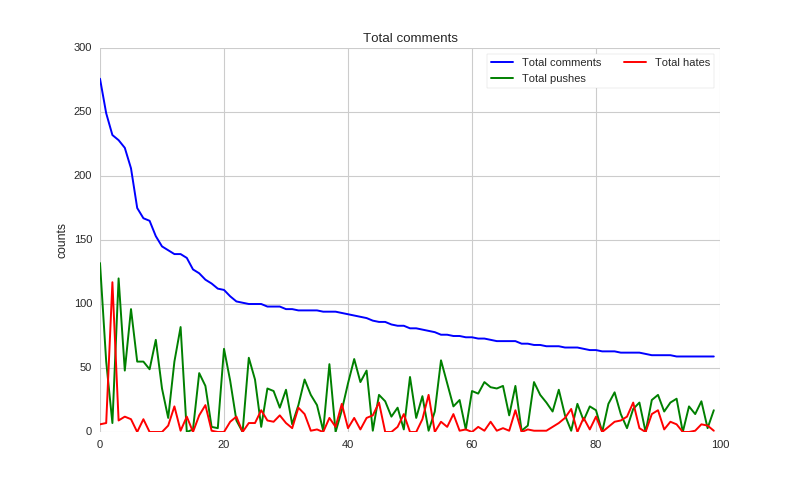

In [5]:
# display pushes
show_distributions(total_comments, total_pushes, total_hates)

# Word Analysis

In [6]:
# grap post
words = []
scores = []

for post in posts:
    d = defaultdict(int)
    content = post['content']
    if post['score'] != 0:
        for l in content.split('\n'):
            if l:
                for w in jieba.cut(l):
                    d[w] += 1
        if len(d) > 0:
            words.append(d)
            scores.append(1 if post['score'] > 0 else 0)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 0.684 seconds.
DEBUG:jieba:Loading model cost 0.684 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


In [7]:
# grap comments
c_words = []
c_scores = []

for post in posts:
    for comment in post['comments']:
        l = comment['content'].strip()
        if l and comment['score'] != 0:
            d = defaultdict(int)
            for w in jieba.cut(l):
                d[w] += 1
            if len(d) > 0:
                c_scores.append(1 if comment['score'] > 0 else 0)
                c_words.append(d)

In [8]:
# convert to vectors
dvec = DictVectorizer()
tfidf = TfidfTransformer()
X = tfidf.fit_transform(dvec.fit_transform(words))

c_dvec = DictVectorizer()
c_tfidf = TfidfTransformer()
c_X = c_tfidf.fit_transform(c_dvec.fit_transform(c_words))

In [9]:
svc = LinearSVC()
svc.fit(X, scores)

c_svc = LinearSVC()
c_svc.fit(c_X, c_scores)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [10]:
def display_top_features(weights, names, top_n, select=abs):
    top_features = sorted(zip(weights, names), key=lambda x: select(x[0]), reverse=True)[:top_n]
    top_weights = [x[0] for x in top_features]
    top_names = [x[1] for x in top_features]

    fig, ax = plt.subplots(figsize=(10,8))
    ind = np.arange(top_n)
    bars = ax.bar(ind, top_weights, color='blue', edgecolor='black')
    for bar, w in zip(bars, top_weights):
        if w < 0:
            bar.set_facecolor('red')

    width = 0.30
    ax.set_xticks(ind + width)
    ax.set_xticklabels(top_names, rotation=45, fontsize=12, fontdict={'fontname': 'Droid Sans Fallback', 'fontsize':12})

    plt.show(fig)

<IPython.core.display.Javascript object>


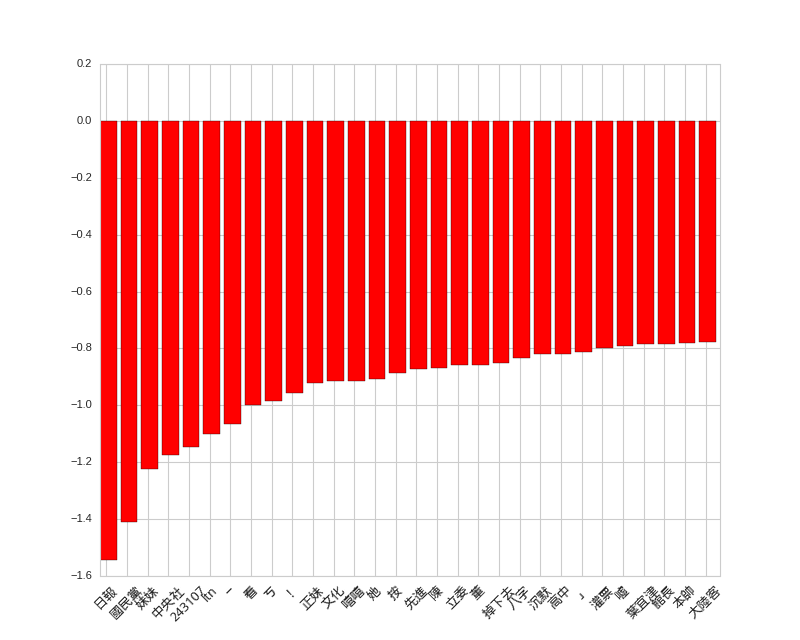

In [11]:
# top features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30)

<IPython.core.display.Javascript object>


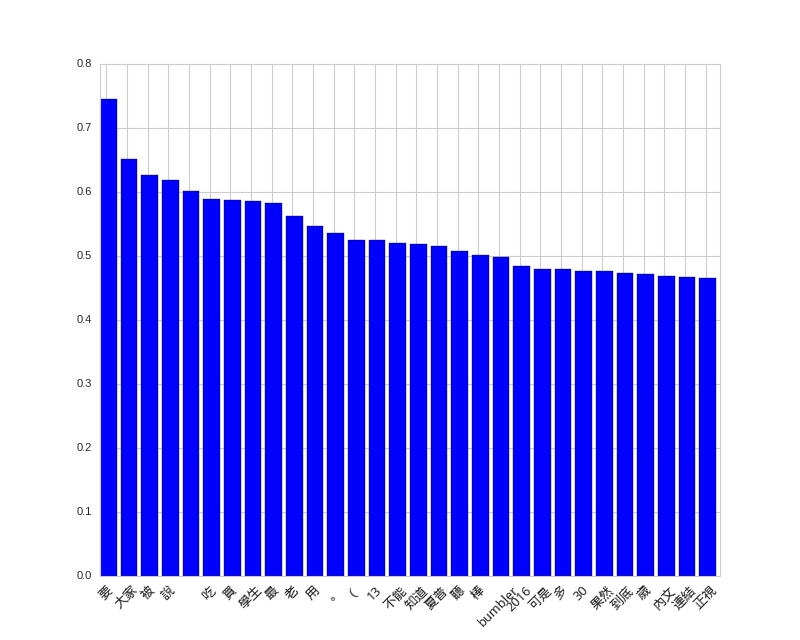

In [12]:
# top positive features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30, select=lambda x: x)

<IPython.core.display.Javascript object>


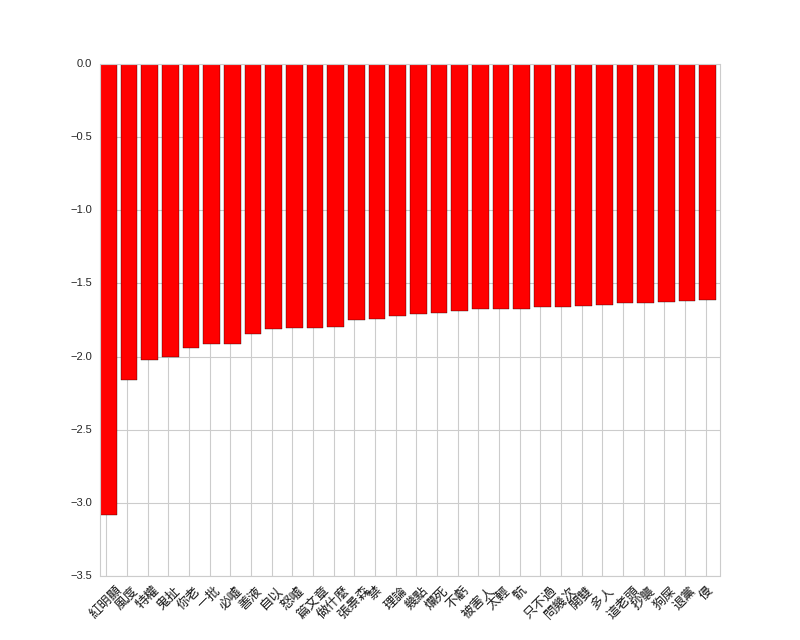

In [13]:
# top features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30)

<IPython.core.display.Javascript object>


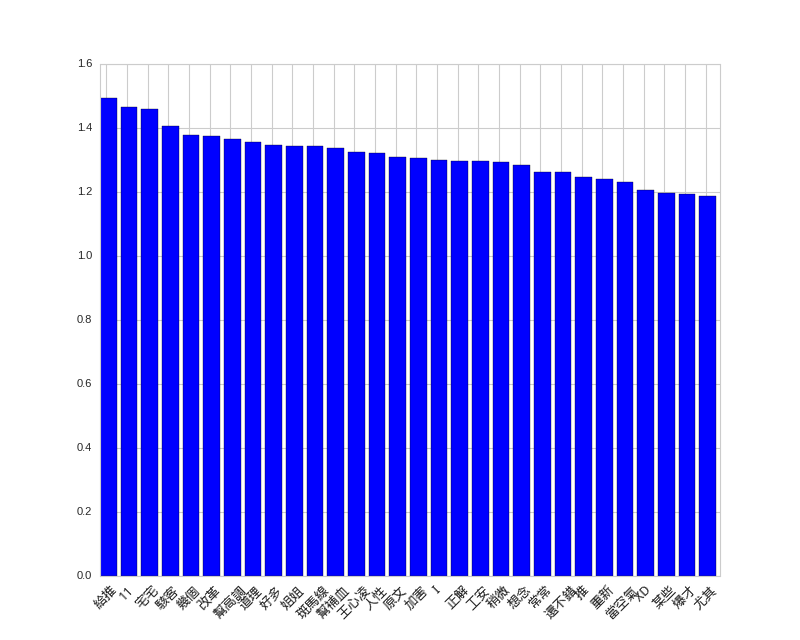

In [14]:
# top positive features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30, select=lambda x: x)